In [1]:
import sys
import pathlib
from itertools import product, tee
from dataclasses import dataclass
from typing import Tuple, List, Optional
import math

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import momepy
from shapely import geometry, ops
from shapely.geometry import LineString
from tqdm.auto import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append("..")

In [5]:
from src.preprocess import transform_df_to_trajectory_gdf
from src.visualize import random_colors

In [6]:
mpl.rcParams["figure.facecolor"] = "w"

# Read traffic lanes

Read traffic lanes as geopandas dataframe

In [7]:
trafficlanes_shapefile = pathlib.Path("../data/raw/rdb1/map_rdb1/shapefiles_trafficlanes")
trafficlanes = gpd.read_file(trafficlanes_shapefile)

In [8]:
trafficlanes.head()

,identifier,type,successors,geometry
0,308840,NORMAL,None,"LINESTRING (619275.680 5809210.783, 619270.841..."
1,308827,NORMAL,"1382090,1382091","LINESTRING (619267.575 5809220.289, 619272.474..."
2,307911,NORMAL,"1381550,1381551","LINESTRING (619301.721 5809211.188, 619289.351..."
3,307900,NORMAL,None,"LINESTRING (619290.881 5809202.915, 619303.266..."
4,1381551,NORMAL,307861,"LINESTRING (619289.351 5809205.791, 619286.761..."


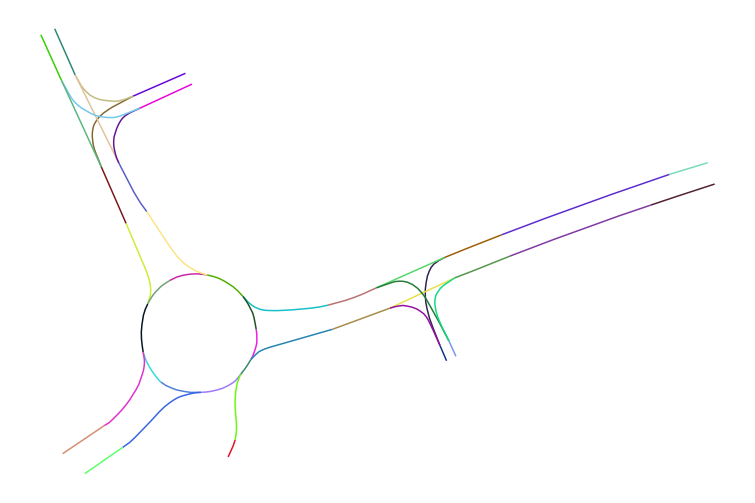

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color=random_colors(len(trafficlanes)), label="traffic lanes")
ax.set_axis_off()
# fig.suptitle("traffic lanes $rdb_1$")

In [10]:
del trafficlanes["successors"]

Read traffic lanes as a `networkx.classes.digraph.DiGraph`

In [11]:
traffic_lanes_graph = momepy.gdf_to_nx(trafficlanes, approach='primal', directed=True, multigraph=False)

In [12]:
traffic_lanes_graph

# Generate possible paths

In [13]:
len(traffic_lanes_graph.nodes), len(traffic_lanes_graph.edges)

(44, 48)

Find nodes with only one incoming and outgoing edge

In [14]:
start_nodes = [node for node, degree in traffic_lanes_graph.in_degree if degree == 0]
end_nodes = [node for node, degree in traffic_lanes_graph.out_degree if degree == 0]

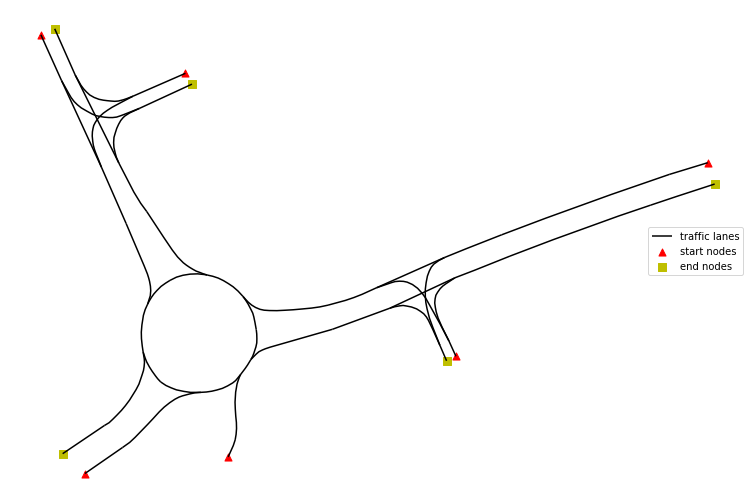

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", label="traffic lanes")

start_nodes_matrix = np.array(start_nodes)
ax.scatter(start_nodes_matrix[:, 0], start_nodes_matrix[:, 1], s=50, color="r", marker="^", label="start nodes")

end_nodes_matrix = np.array(end_nodes)
ax.scatter(end_nodes_matrix[:, 0], end_nodes_matrix[:, 1], s=50, color="y", marker="s", label="end nodes")

ax.legend(loc=5)
ax.set_axis_off()

Find all possible paths between the combination of start- and end nodes

In [16]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [17]:
def graph_path_to_linestring(G, path: List[int]) -> LineString:
    lines = list()
    for n0, n1 in pairwise(path):
        geometry = G.edges[n0, n1]['geometry']
        lines.append(geometry)
    ls = ops.linemerge(lines)
    return ls

In [18]:
@dataclass
class DrivablePath:
    """Data structure representing a drivable path (extracted from the map graph)
    """
    id: int
    path: LineString
    
    def plot(self, ax, color=None):
        ls = self.path
        x, y = ls.xy
        ax.plot(x, y, label=str(self.id), color=color, lw=3)
        ax.scatter([x[0]], [y[0]], color=color, marker="^")
        ax.scatter([x[-1]], [y[-1]], color=color, marker="s")
    
    @property
    def length(self) -> float:
        ls = self.path
        return ls.length

In [19]:
paths = list()
for i, (start, end) in enumerate(product(start_nodes, end_nodes)):
    
    # find path
    path = nx.shortest_path(traffic_lanes_graph, start, end)
    
    # convert to linestring
    path_as_ls = graph_path_to_linestring(traffic_lanes_graph, path)
    
    paths.append(DrivablePath(i, path_as_ls))

In [20]:
num_paths = len(paths)

In [21]:
print(num_paths, "paths found!")

30 paths found!


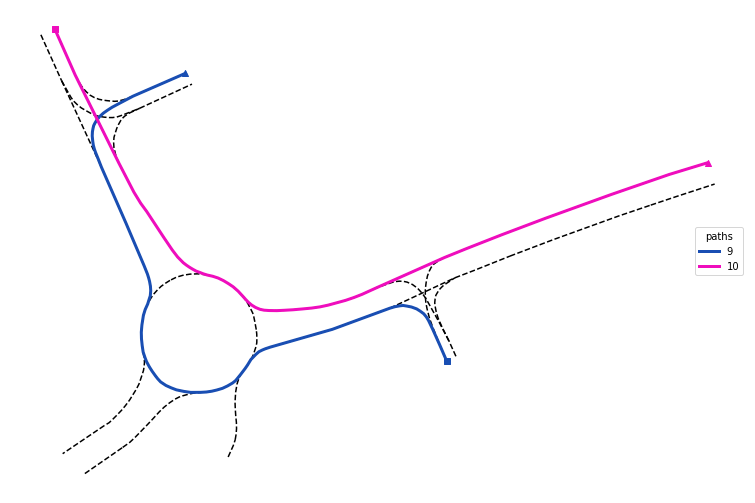

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", linestyle="--")

N = 2
colors = random_colors(N, seed=43)

for i, dp in enumerate(paths[9:9+N]):
    dp.plot(ax, color=colors[i])

ax.legend(title="paths", loc=5)
ax.set_axis_off()

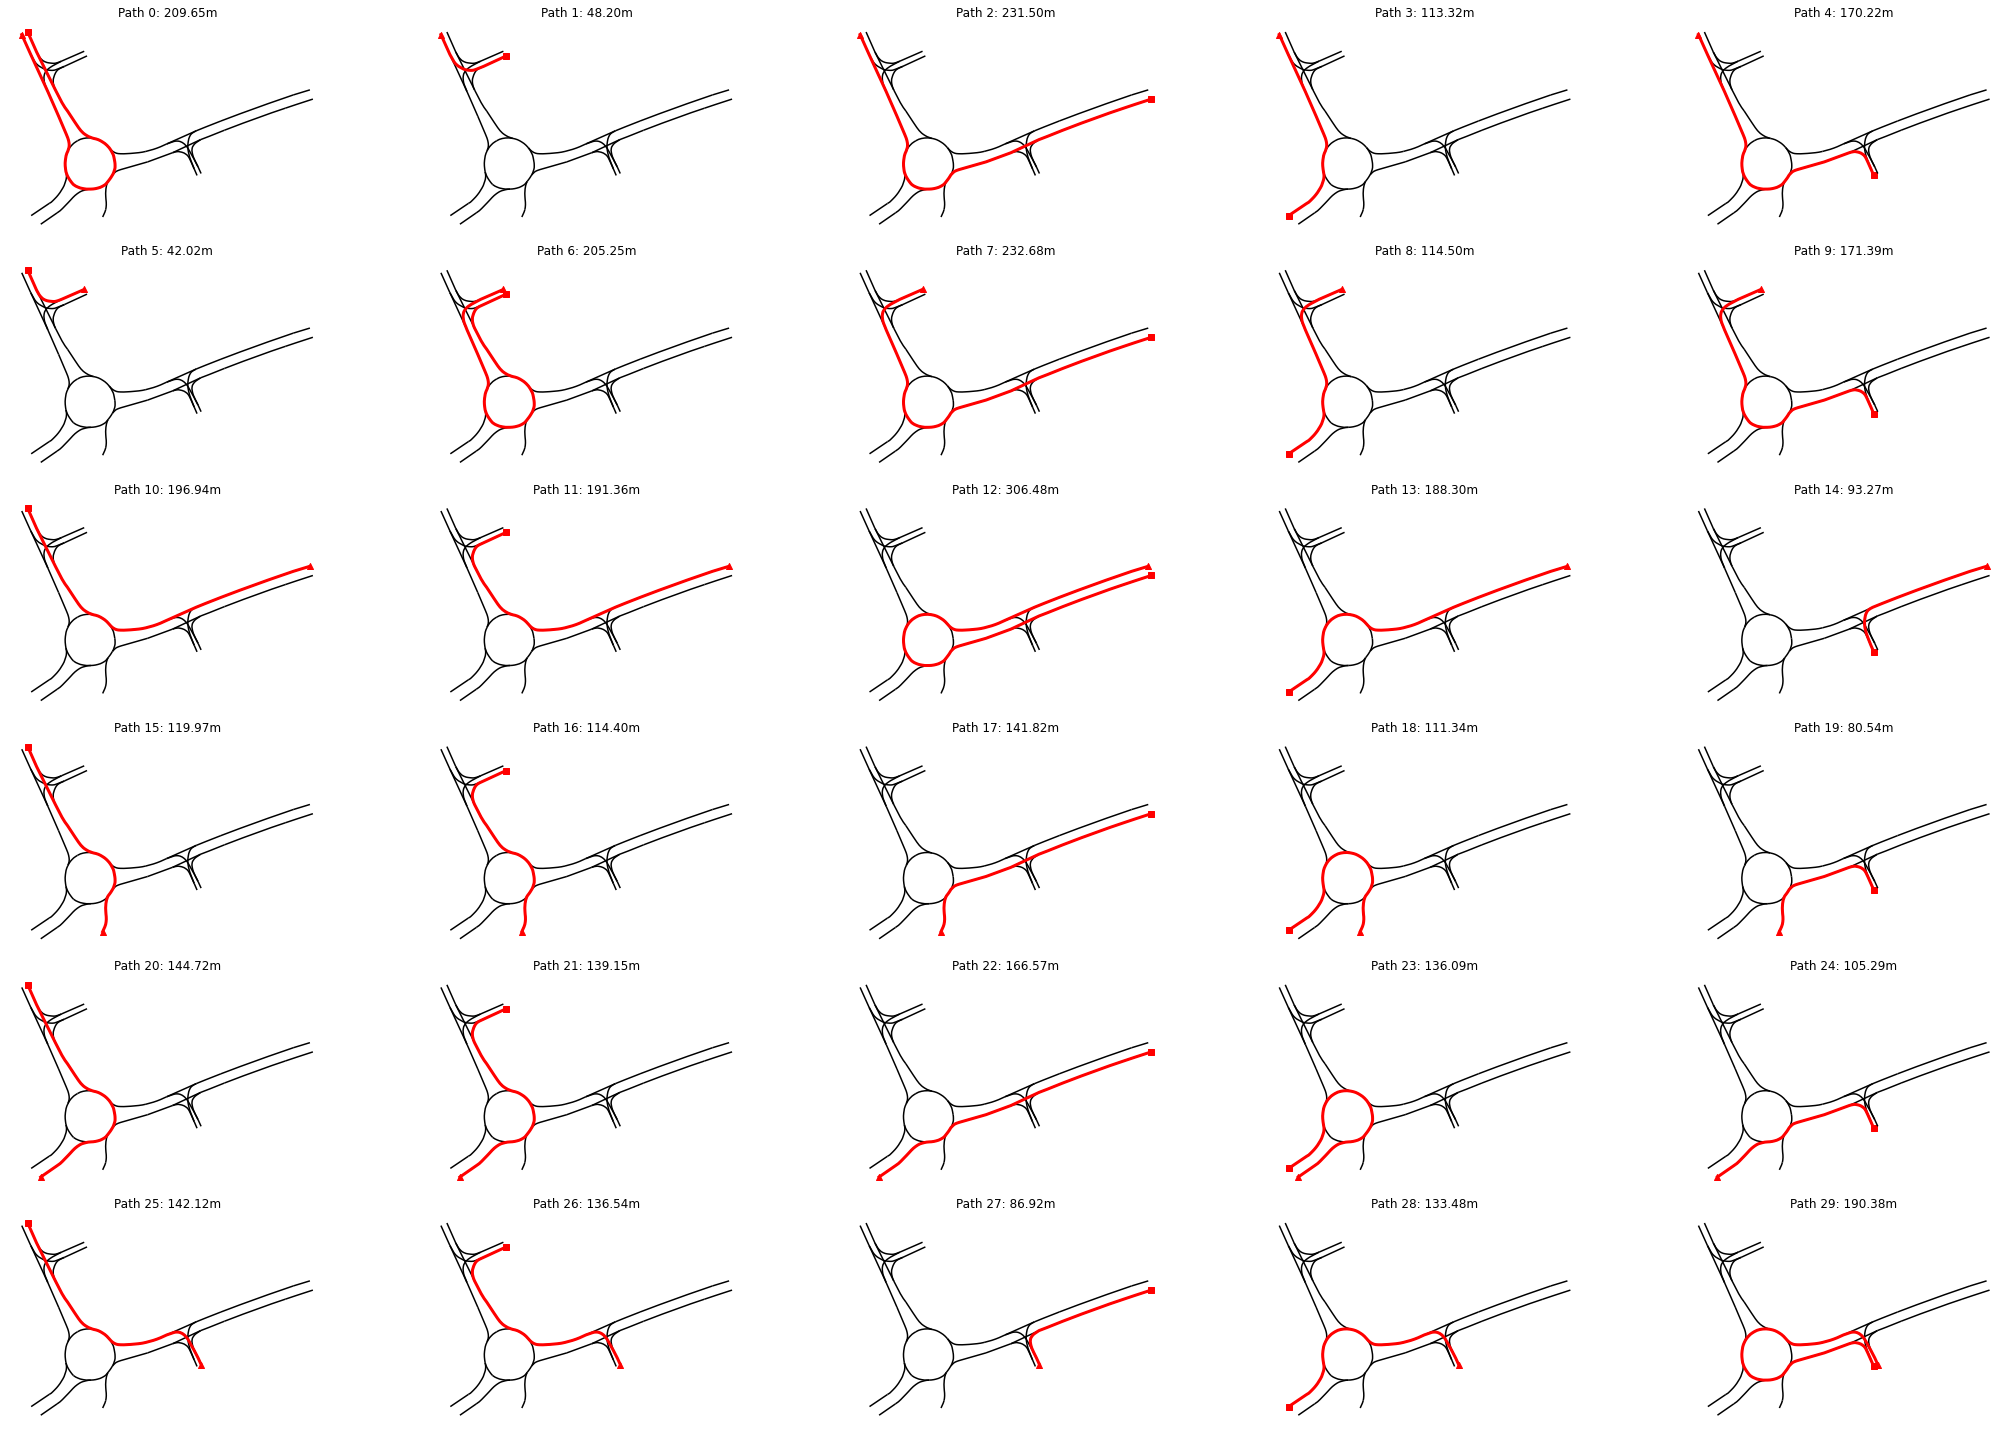

In [23]:
fig, axs = plt.subplots(nrows=math.ceil(num_paths/5), ncols=5, figsize=(30, 20))
axs = axs.flatten()

for i, dp in enumerate(paths):
    axi = axs[i]
    trafficlanes.plot(ax=axi, color="k", label="traffic lanes")
    dp.plot(axi, color="red")
    axi.set_axis_off()
    axi.set_title(f"Path {i}: {dp.length:.2f}m")
plt.tight_layout()

# Read vehicle trajectory data

## Trajectory class

In [24]:
from src.utils import common_time

In [25]:
@dataclass
class Trajectory:
    """Helper class to work with generic trajectories
    """
    
    id: int
    X: pd.DataFrame  # time as index, columns as state features
    
    def plot(self, axs: List[mpl.axes.Axes], columns: Optional[List[str]] = None, plot_kwargs: dict = dict()):
        
        X = self.X
        
        if columns is None:
            signals_to_plot = self.names
        else:
            signals_to_plot = columns
            
        assert len(axs) == len(signals_to_plot), "Number of state variables and provided axes is not equal."
        
        for ax, col in zip(axs, signals_to_plot):
            ax.plot(X.index, X[col], **plot_kwargs)
    
    @property
    def dim(self) -> int:
        return len(self.X.columns)
    
    @property
    def name(self) -> int:
        return self.id
    
    @property
    def time(self):
        return self.X.index
    
    @property
    def names(self) -> List[str]:
        return list(self.X.columns)
    
    @classmethod
    def from_trace(cls, trace: pd.Series, columns: List[str], sample_rate: float = 30):
        name = trace.name
        start_time = trace["START_TIME"]
        num_samples = trace["NUM_SAMPLES"]
        time = np.arange(num_samples)/sample_rate + start_time
        df = pd.DataFrame(
            data = {c: trace[c] for c in columns},
            index = time
        )
        return cls(name, df)
    
    def temporal_intersection(self, traj: "Trajectory") -> Tuple[float, float]:
        tp1 = self.time[0], self.time[-1]
        tp2 = traj.time[0], traj.time[-1]
        return common_time(tp1, tp2)
    
    def get(self, variable: str) -> pd.Series:
        return self.X[variable]
    
    def sample(self, t) -> pd.Series:
        i_prev = np.argmax(self.X.index >= t )
        return self.X.iloc[i_prev]

In [26]:
from src.opendd import VEHICLE_CLASSES
from src.preprocess import transform_df_to_trajectory_gdf

In [27]:
data_path = "../data/raw/rdb1.parquet"

In [28]:
VEHICLE_SAMPLE_RATE = 30.0

In [29]:
df = pd.read_parquet(data_path)

In [30]:
df.sample(10)

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,table
17357799,115190,115191,457.790667,29905,619332.96,5809155.27,3.375985,5.92,0.9884,0.9613,-0.2298,Car,1.8473,4.4993,rdb1_142
13527365,3266,3267,5.238567,22821,619346.22,5809160.01,3.549785,7.56,1.2381,0.2559,-1.2114,Car,1.9399,4.8985,rdb1_107
11463510,25969,25970,146.546400,19029,619328.67,5809154.97,3.276985,5.28,1.2115,1.2068,0.1071,Car,1.8527,4.1658,rdb1_85
19019328,92480,92481,177.076900,32636,619301.80,5809166.70,2.389685,8.41,2.3861,1.7471,1.6252,Car,1.8548,4.6546,rdb1_153
15749518,1868,1869,51.951900,26885,619309.09,5809123.33,1.522285,0.41,0.2461,-0.0941,0.2274,Pedestrian,0.8333,0.8333,rdb1_128
9807428,93220,93221,412.478733,15830,619366.65,5809159.44,3.086785,0.70,0.6362,-0.6350,0.0388,Pedestrian,0.8333,0.8333,rdb1_65
13666351,142252,142253,522.321800,23075,619289.54,5809137.49,4.376785,5.73,1.3388,1.3360,0.0858,Car,2.0000,4.9059,rdb1_107
4848580,77137,77138,240.406833,7587,619305.90,5809161.74,3.041585,6.71,2.9324,-2.9311,0.0859,Car,1.7002,3.6075,rdb1_30
13821644,106501,106502,387.854133,23363,619346.73,5809154.91,0.392285,8.95,0.6076,-0.2313,0.5618,Car,2.0000,4.3710,rdb1_109
11459158,21617,21618,128.695233,19022,619336.40,5809156.32,3.411985,2.26,1.2272,0.0414,-1.2265,Car,1.7521,3.7657,rdb1_85


In [31]:
df["k"] = (df["TIMESTAMP"] * VEHICLE_SAMPLE_RATE).round().astype(int)

In [32]:
df.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,table,k
0,0,1,0.000000,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,rdb1_1,0
1,1,2,0.033367,1,619302.47,5809133.85,0.452985,4.75,0.1341,-0.1156,0.0679,Heavy Vehicle,2.7892,6.0217,rdb1_1,1
2,2,3,0.066733,1,619302.61,5809133.91,0.452485,4.75,0.1316,-0.1063,0.0776,Heavy Vehicle,2.7892,6.0217,rdb1_1,2
3,3,4,0.100100,1,619302.76,5809133.98,0.451985,4.75,0.1368,-0.0920,0.1013,Heavy Vehicle,2.7892,6.0217,rdb1_1,3
4,4,5,0.133467,1,619302.90,5809134.05,0.451485,4.76,0.1568,-0.0729,0.1388,Heavy Vehicle,2.7892,6.0217,rdb1_1,4


In [33]:
df = df[df["table"] == "rdb1_1"]

In [34]:
df.sample(10)

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,table,k
204487,204487,204488,528.160967,324,619324.63,5809145.30,0.424985,8.78,0.9418,0.1291,0.9329,Car,1.9721,4.8418,rdb1_1,15845
73196,73196,73197,210.310100,124,619289.42,5809172.09,5.136485,0.07,0.0914,-0.0829,-0.0384,Car,1.9512,4.6897,rdb1_1,6309
123531,123531,123532,348.581567,210,619336.17,5809156.23,3.416485,2.63,0.7120,0.0158,-0.7118,Car,1.9066,4.4952,rdb1_1,10457
205344,205344,205345,532.832300,326,619320.33,5809143.64,0.539785,7.17,1.3915,1.3604,0.2924,Car,1.9592,4.2718,rdb1_1,15985
99309,99309,99310,299.832867,174,619317.30,5809156.78,2.758885,4.93,1.4123,0.6156,1.2711,Car,1.6476,3.9965,rdb1_1,8995
75884,75884,75885,220.420200,129,619309.69,5809160.87,2.801585,5.76,1.7770,-1.7741,-0.1021,Car,2.0801,4.7506,rdb1_1,6613
127100,127100,127101,350.383367,215,619310.84,5809138.15,0.473785,7.90,1.2392,-0.5873,1.0912,Car,1.9005,4.4265,rdb1_1,10512
42539,42539,42540,113.046267,72,619310.25,5809160.07,2.756285,6.03,1.4891,-1.4781,-0.1799,Car,1.8392,4.1343,rdb1_1,3391
115761,115761,115762,330.263267,199,619318.50,5809148.24,1.289885,3.69,1.0879,-1.0832,0.1015,Bus,3.1344,10.3887,rdb1_1,9908
159986,159986,159987,412.245167,252,619295.45,5809129.77,0.726585,0.35,0.4999,0.0817,-0.4932,Car,2.0315,4.2228,rdb1_1,12367


In [35]:
gdf_traces = transform_df_to_trajectory_gdf(df)

In [36]:
gdf_traces["START_TIME_DISCRETE"] = (gdf_traces["START_TIME"] * VEHICLE_SAMPLE_RATE).round().astype(int)

Transform data frame from samples to trajectories (timeseries)

In [37]:
# keep only motorized vehicles
gdf_traces = gdf_traces[gdf_traces["CLASS"].isin(VEHICLE_CLASSES)]

In [38]:
gdf_traces.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 332 entries, 1 to 356
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   CLASS                332 non-null    object  
 1   WIDTH                332 non-null    float64 
 2   LENGTH               332 non-null    float64 
 3   START_TIME           332 non-null    float64 
 4   NUM_SAMPLES          332 non-null    int64   
 5   V                    332 non-null    object  
 6   ACC                  332 non-null    object  
 7   geometry             332 non-null    geometry
 8   START_TIME_DISCRETE  332 non-null    int32   
dtypes: float64(3), geometry(1), int32(1), int64(1), object(3)
memory usage: 24.6+ KB


In [39]:
gdf_traces.head()

,CLASS,WIDTH,LENGTH,START_TIME,NUM_SAMPLES,V,ACC,geometry,START_TIME_DISCRETE
OBJID,,,,,,,,,
1,Heavy Vehicle,2.7892,6.0217,0.0,341,"[4.74, 4.75, 4.75, 4.75, 4.76, 4.76, 4.77, 4.7...","[0.1415, 0.1341, 0.1316, 0.1368, 0.1568, 0.254...","LINESTRING (619302.330 5809133.780, 619302.470...",0
2,Car,1.7950,4.3806,0.0,556,"[0.33, 0.34, 0.34, 0.35, 0.36, 0.37, 0.39, 0.4...","[0.1092, 0.1466, 0.1976, 0.285, 0.4123, 0.5232...","LINESTRING (619286.670 5809178.010, 619286.680...",0
3,Car,1.8667,3.7854,0.0,241,"[1.32, 1.32, 1.32, 1.32, 1.32, 1.31, 1.31, 1.3...","[0.0693, 0.0556, 0.0376, 0.0246, 0.0954, 0.177...","LINESTRING (619281.510 5809126.720, 619281.470...",0
4,Car,1.7642,4.4819,0.0,286,"[3.78, 3.75, 3.72, 3.68, 3.64, 3.6, 3.56, 3.52...","[0.9199, 1.0231, 1.1121, 1.1865, 1.2474, 1.308...","LINESTRING (619288.840 5809134.990, 619288.780...",0
5,Medium Vehicle,2.1041,4.8186,0.0,216,"[4.6, 4.63, 4.66, 4.69, 4.72, 4.75, 4.78, 4.82...","[1.3951, 1.5709, 1.7314, 1.8746, 2.0001, 2.119...","LINESTRING (619316.990 5809146.380, 619317.010...",0


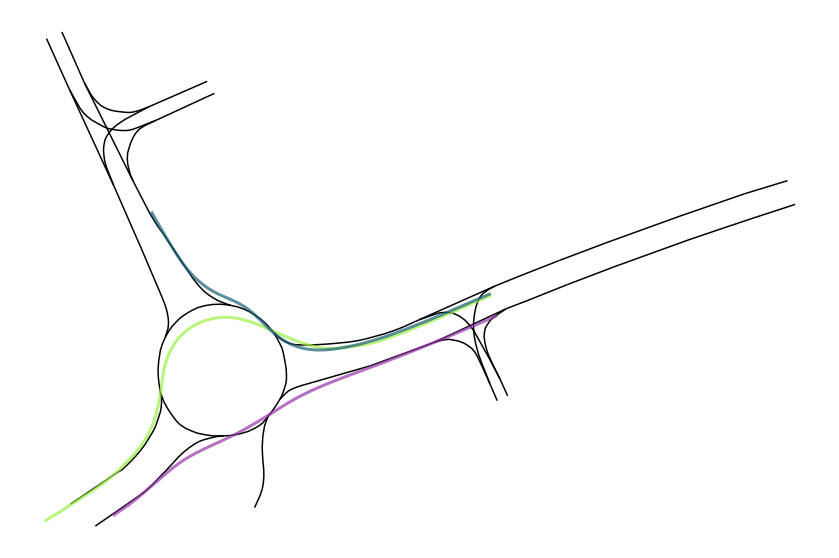

In [40]:
N = 3

fig, ax = plt.subplots(figsize=(15, 10))
trafficlanes.plot(ax=ax, color="k")

colors = random_colors(N, seed=115)
gdf_traces.sample(N, random_state=115).plot(ax=ax, alpha=0.7, lw=3, color=colors)

# cx.add_basemap(ax, crs=gdf_traces_vehicle.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom="auto")
ax.set_axis_off()

## Add driving states

In [41]:
from src.preprocess import VehicleState, identify_driving_state

In [42]:
identify_driving_state?

Signature:
identify_driving_state(
    trace: pandas.core.series.Series,
    standing_vel_threshold: float = 0.2,
    standing_acc_threshold: float = 0.5,
) -> numpy.ndarray
Docstring:
Identify driving state (driving vs. standing) based on object's velocity and acceleration.

Args:
    trace (pd.Series): trajectory data
    standing_vel_threshold (float, optional): Maximal velocity while standing. Defaults to 0.2.
    standing_acc_threshold (float, optional): Maximal velocity while standing. Defaults to 0.5.

Returns:
    np.ndarray: integer array of size `len(trace["V"])` with vehicle states,
        see `VehicleState`
File:      c:\users\kopyt\code\opendd-analysis\src\preprocess.py
Type:      function


In [43]:
gdf_traces["STATE"] = gdf_traces.apply(lambda row: identify_driving_state(row), axis=1)

In [44]:
len(gdf_traces)

332

In [45]:
vp1 = gdf_traces.iloc[101]
vp2 = gdf_traces.iloc[104]
traj1 = Trajectory.from_trace(vp1, ["V", "ACC", "STATE"])
traj2 = Trajectory.from_trace(vp2, ["V", "ACC", "STATE"])

Text(0.5, 0, 'time [s]')

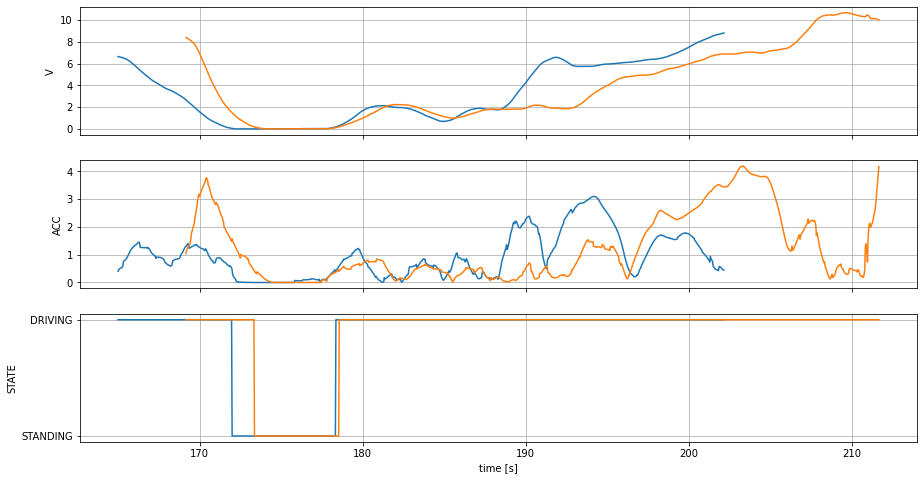

In [46]:
fig, axs = plt.subplots(nrows=traj1.dim, figsize=(15, 8), sharex=True)

for i, ax in enumerate(axs):
    ax.set_ylabel(traj1.names[i])
    ax.grid()

traj1.plot(axs)
traj2.plot(axs)

axs[-1].set_yticks([VehicleState.STANDING.value, VehicleState.DRIVING.value])
axs[-1].set_yticklabels([VehicleState.STANDING.name, VehicleState.DRIVING.name])




axs[-1].set_xlabel("time [s]")

In [47]:
str(VehicleState.DRIVING.name)

'DRIVING'

# Assign trajectory data to paths

## Single vehicle example

In [48]:
vehicle_path = gdf_traces.iloc[1]

In [49]:
vehicle_path

CLASS                                                                Car
WIDTH                                                              1.795
LENGTH                                                            4.3806
START_TIME                                                           0.0
NUM_SAMPLES                                                          556
V                      [0.33, 0.34, 0.34, 0.35, 0.36, 0.37, 0.39, 0.4...
ACC                    [0.1092, 0.1466, 0.1976, 0.285, 0.4123, 0.5232...
geometry               LINESTRING (619286.67 5809178.01, 619286.68000...
START_TIME_DISCRETE                                                    0
STATE                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 2, dtype: object

In [50]:
vehicle_path_linestring = vehicle_path.geometry

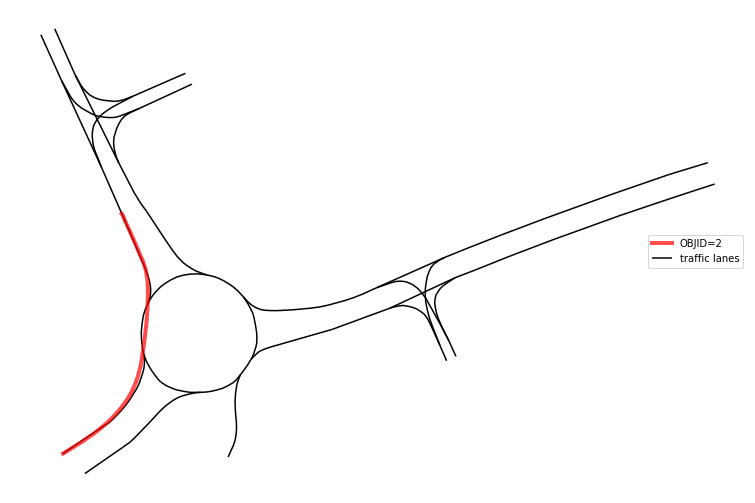

In [51]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", label="traffic lanes")
ax.plot(*vehicle_path_linestring.xy, lw=4, c="red", alpha=0.7, label=f"OBJID={vehicle_path.name}")
ax.set_axis_off()
ax.legend(loc=5)

In [52]:
from scipy.spatial.distance import directed_hausdorff
from shapely.geometry import LineString

In [53]:
def compute_path_distance(ls1: LineString, ls2: LineString, N: int = 100) -> float:
    
    # linestrings have to be distretized to call `scipy.spatial.distance.directed_hausdorff`
    ls1_pts = LineString([ls1.interpolate(s, normalized=True) for s in np.linspace(0, 1, N)])
    ls1_pts = np.array(ls1_pts.xy).T  # N x 2
    
    ls2_pts = LineString([ls2.interpolate(s, normalized=True) for s in np.linspace(0, 1, N)])
    ls2_pts = np.array(ls2.xy).T
    
    # d = ls1.hausdorff_distance(ls2)
    
    d = directed_hausdorff(ls1_pts, ls2_pts)[0]
    return d

In [54]:
distances = list()

N = 100

for i, dp in enumerate(paths):
    
    d = compute_path_distance(vehicle_path_linestring, dp.path, N)
    distances.append(d)

distances = np.array(distances)

In [55]:
distances

array([28.49061682, 80.06795936, 28.49061682,  5.75742858, 28.49061682,
       84.02277521, 28.49061682, 28.49061682,  5.75742858, 28.49061682,
       53.18809294, 53.18809294, 28.49061682, 19.39490101, 92.26269721,
       38.99208628, 38.99208628, 45.91473764, 19.39490101, 45.91473764,
       17.86996647, 17.86996647, 45.35059148, 19.39490101, 45.35059148,
       53.18809294, 53.18809294, 94.18546821, 19.39490101, 28.49061682])

In [56]:
print(distances.argmin())

3


In [57]:
distances

array([28.49061682, 80.06795936, 28.49061682,  5.75742858, 28.49061682,
       84.02277521, 28.49061682, 28.49061682,  5.75742858, 28.49061682,
       53.18809294, 53.18809294, 28.49061682, 19.39490101, 92.26269721,
       38.99208628, 38.99208628, 45.91473764, 19.39490101, 45.91473764,
       17.86996647, 17.86996647, 45.35059148, 19.39490101, 45.35059148,
       53.18809294, 53.18809294, 94.18546821, 19.39490101, 28.49061682])

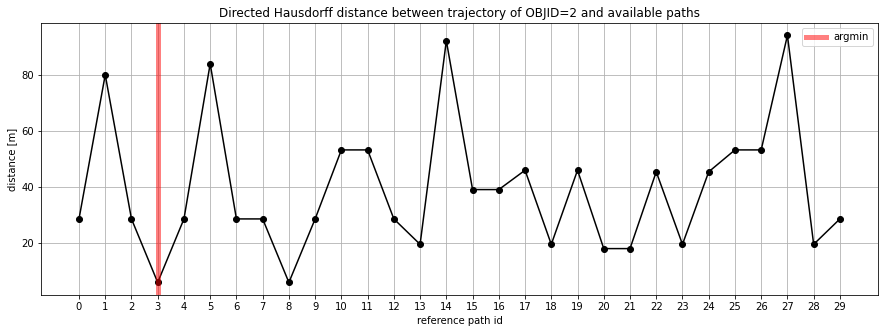

In [58]:
plt.figure(figsize=(15, 5))
plt.plot(distances, "ko-")
plt.axvline(distances.argmin(), color="r", label="argmin", lw=5, alpha=0.5)
plt.grid()
plt.xlabel("reference path id")
plt.ylabel("distance [m]")
plt.xticks(np.arange(len(paths)), np.arange(len(paths)));
plt.title(f"Directed Hausdorff distance between trajectory of OBJID={vehicle_path.name} and available paths")
plt.legend()

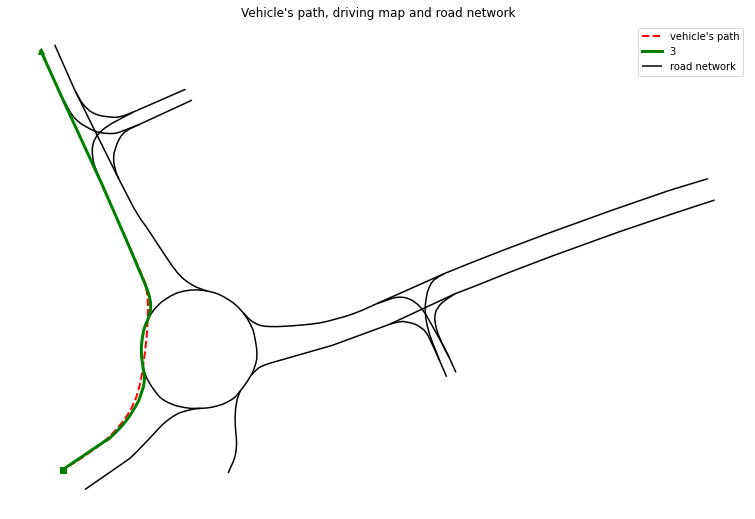

In [59]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", label="road network")
ax.plot(*vehicle_path_linestring.xy, lw=2, c="red", ls="--", label="vehicle's path")
paths[distances.argmin()].plot(ax, color="green")
ax.set_axis_off()
ax.set_title("Vehicle's path, driving map and road network")
ax.legend()

## Multiple vehicles

In [60]:
paths_as_linestrings = [dp.path for dp in paths]

In [61]:
def find_nearest_path(ls: LineString, paths: List[LineString], N: int = 100) -> int:
    """Returns the index of the path list `paths` with minimal distance to `ls` wrt. to
    `directed_hausdorff` metric.
    """
    
    distances = np.zeros(len(paths), dtype=float)
    
    for i, path in enumerate(paths):
    
        d = compute_path_distance(ls, path, N)
        distances[i] = d

    return distances.argmin()

In [62]:
tqdm.pandas()

In [63]:
gdf_traces["path_id"] = gdf_traces.progress_apply(lambda row: find_nearest_path(row["geometry"], paths_as_linestrings, N=20), axis=1)

  0%|          | 0/332 [00:00<?, ?it/s]

In [64]:
gdf_traces.head()

,CLASS,WIDTH,LENGTH,START_TIME,NUM_SAMPLES,V,ACC,geometry,START_TIME_DISCRETE,STATE,path_id
OBJID,,,,,,,,,,,
1,Heavy Vehicle,2.7892,6.0217,0.0,341,"[4.74, 4.75, 4.75, 4.75, 4.76, 4.76, 4.77, 4.7...","[0.1415, 0.1341, 0.1316, 0.1368, 0.1568, 0.254...","LINESTRING (619302.330 5809133.780, 619302.470...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,Car,1.7950,4.3806,0.0,556,"[0.33, 0.34, 0.34, 0.35, 0.36, 0.37, 0.39, 0.4...","[0.1092, 0.1466, 0.1976, 0.285, 0.4123, 0.5232...","LINESTRING (619286.670 5809178.010, 619286.680...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3
3,Car,1.8667,3.7854,0.0,241,"[1.32, 1.32, 1.32, 1.32, 1.32, 1.31, 1.31, 1.3...","[0.0693, 0.0556, 0.0376, 0.0246, 0.0954, 0.177...","LINESTRING (619281.510 5809126.720, 619281.470...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3
4,Car,1.7642,4.4819,0.0,286,"[3.78, 3.75, 3.72, 3.68, 3.64, 3.6, 3.56, 3.52...","[0.9199, 1.0231, 1.1121, 1.1865, 1.2474, 1.308...","LINESTRING (619288.840 5809134.990, 619288.780...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3
5,Medium Vehicle,2.1041,4.8186,0.0,216,"[4.6, 4.63, 4.66, 4.69, 4.72, 4.75, 4.78, 4.82...","[1.3951, 1.5709, 1.7314, 1.8746, 2.0001, 2.119...","LINESTRING (619316.990 5809146.380, 619317.010...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


In [65]:
gdf_traces["START_TIME"].iloc[:20]

OBJID
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9      0.000000
11     0.000000
13     2.836167
14     4.504500
15     5.672333
16     6.840167
17     8.008000
18    10.176833
19    11.678333
20    14.347667
21    15.181833
24    17.350667
Name: START_TIME, dtype: float64

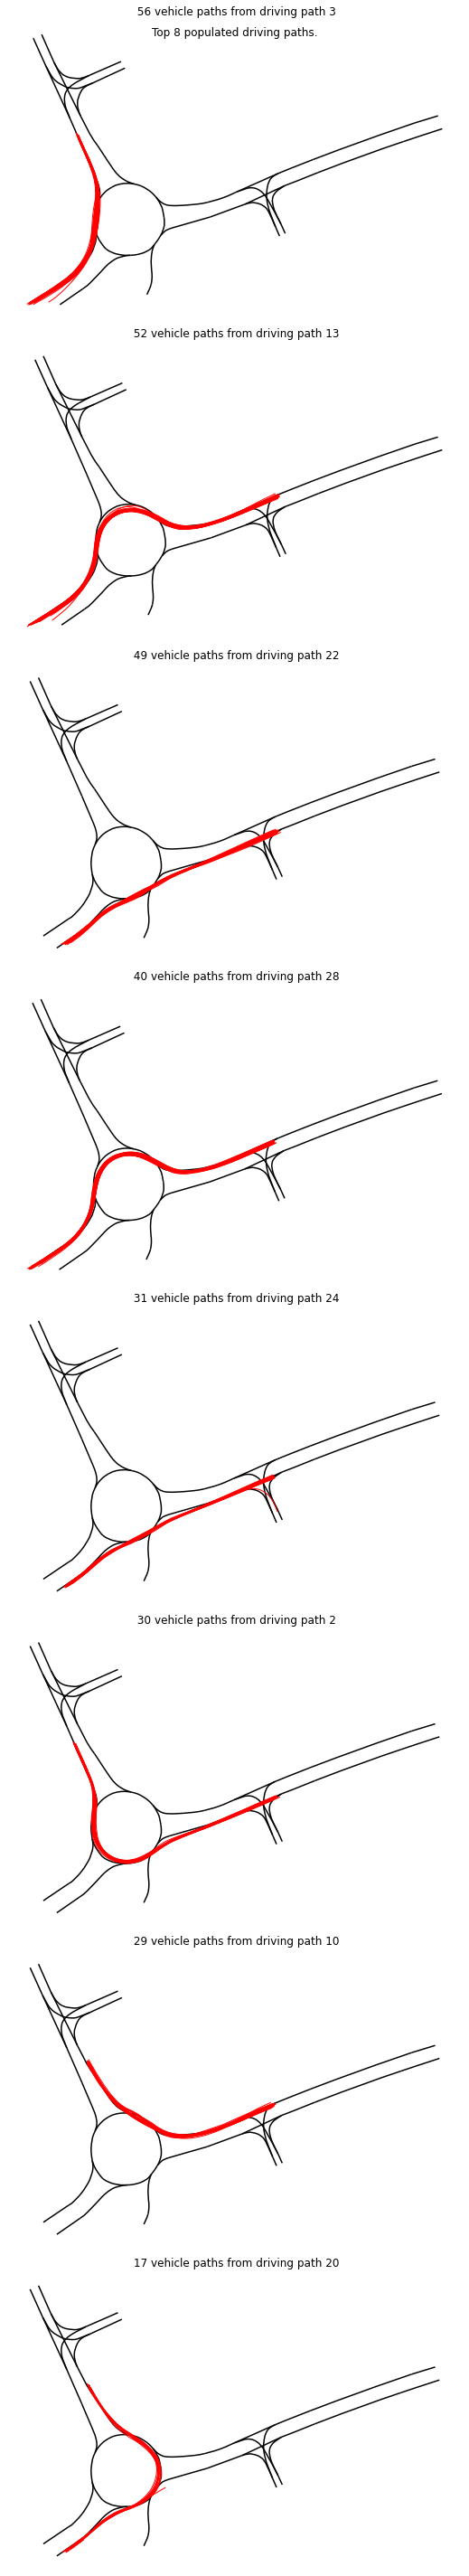

In [66]:
N = 8

fig, axs = plt.subplots(nrows=N, figsize=(10, 5*N))

toplist_path = gdf_traces["path_id"].value_counts()

for i, (path_id, cnt) in enumerate(toplist_path.iloc[:N].iteritems()):
    
    ax = axs[i]
    trafficlanes.plot(ax=ax, color="k", label="traffic lanes")
    
    vehicle_paths = gdf_traces[gdf_traces["path_id"]==path_id]
    
    for i, vp in vehicle_paths.iterrows():
        ax.plot(*vp.geometry.xy, lw=1, color="r")
    ax.set_axis_off()
    ax.set_title(f"{cnt: d} vehicle paths from driving path {path_id:d}")
    
fig.suptitle(f"Top {N} populated driving paths.")
plt.tight_layout()

# Project to Frenet Frame

Helpful link: https://fjp.at/posts/optimal-frenet/

## Example on single trajectory

In [67]:
@dataclass
class DiscreteReferencePath:
    
    points: np.ndarray  # in cartesian (metric) coordinates, as Nx3 (s, x, y)
    spatial_resolution: float  # approximate
    
    def to_frenet(self, pt: Tuple[float, float]) -> Tuple[float, float]:
        """Transform a cartesian coordinate to a Frenet coordinate.

        Args:
            pt (Tuple[float, float]): cartesian coordinate (x, y)

        Returns:
            Tuple[float, float]: frenet coordinate (s, d)
        """
        
        pt = np.array(pt)
        
        # compute distances to each sample of the ref.-path
        deltas = np.linalg.norm(self.points[:, 1:] - pt, axis=1)
        
        # take the index of the minium
        idx_min = np.argmin(deltas)
        
        # arc length
        s = self.points[idx_min, 0]
        # perpendicular distance
        d = deltas[idx_min]
        return s,  d
    
    def to_cartesian(self, s: float, d: 0):
        # needs to implement normal unit vector
        pass
    
    @property
    def length(self) -> float:
        return self.points[-1, 0] + self.spatial_resolution
    
    @classmethod
    def from_linestring(cls, ls: LineString, resolution=1.0, cut_length: float = 1.0):
        
        path_samples = np.arange(cut_length, ls.length-cut_length, resolution)
        ls_pts = LineString([ls.interpolate(s, normalized=False) for s in path_samples])
        ls_pts = np.array(ls_pts.xy).T  # N x 2
        
        return cls(np.c_[path_samples, ls_pts], resolution)
    
    def to_frenet_vectorized(self, x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        
        F = np.zeros((len(x), 2))
        
        for i, (x_pt, y_pt) in enumerate(zip(x, y)):
             F[i, :] = self.to_frenet((x_pt, y_pt))
        
        return F[:, 0], F[:, 1]
    
    def linestring_to_frenet(self, ls: LineString) -> LineString:
        s_arr, d_arr = self.to_frenet_vectorized(*ls.xy)
        return LineString([(s, d) for s, d in zip(s_arr, d_arr)])
    
    def as_linestring(self) -> LineString:
        return LineString([(x, y) for x, y in zip(self.points[:, 1], self.points[:, 2])])
    
    def __str__(self):
        return f"<DiscreteReferencePath with {self.points.shape[0]} samples>"

In [68]:
example_path = paths_as_linestrings[13]
example_reference = DiscreteReferencePath.from_linestring(example_path, 0.1)

In [69]:
example_reference.length

187.40000000000015

In [70]:
example_trip = gdf_traces[gdf_traces["path_id"] == 13].iloc[10]
example_trip

CLASS                                                                Car
WIDTH                                                             1.9112
LENGTH                                                            4.2946
START_TIME                                                    272.438833
NUM_SAMPLES                                                          591
V                      [1.6, 1.6, 1.6, 1.61, 1.61, 1.62, 1.63, 1.64, ...
ACC                    [0.133, 0.0986, 0.0444, 0.0354, 0.1215, 0.1877...
geometry               LINESTRING (619362.96 5809167.38, 619362.91 58...
START_TIME_DISCRETE                                                 8173
STATE                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
path_id                                                               13
Name: 162, dtype: object

In [71]:
example_trip_frenet = example_reference.linestring_to_frenet(example_trip.geometry)

(-10.0, 10.0)

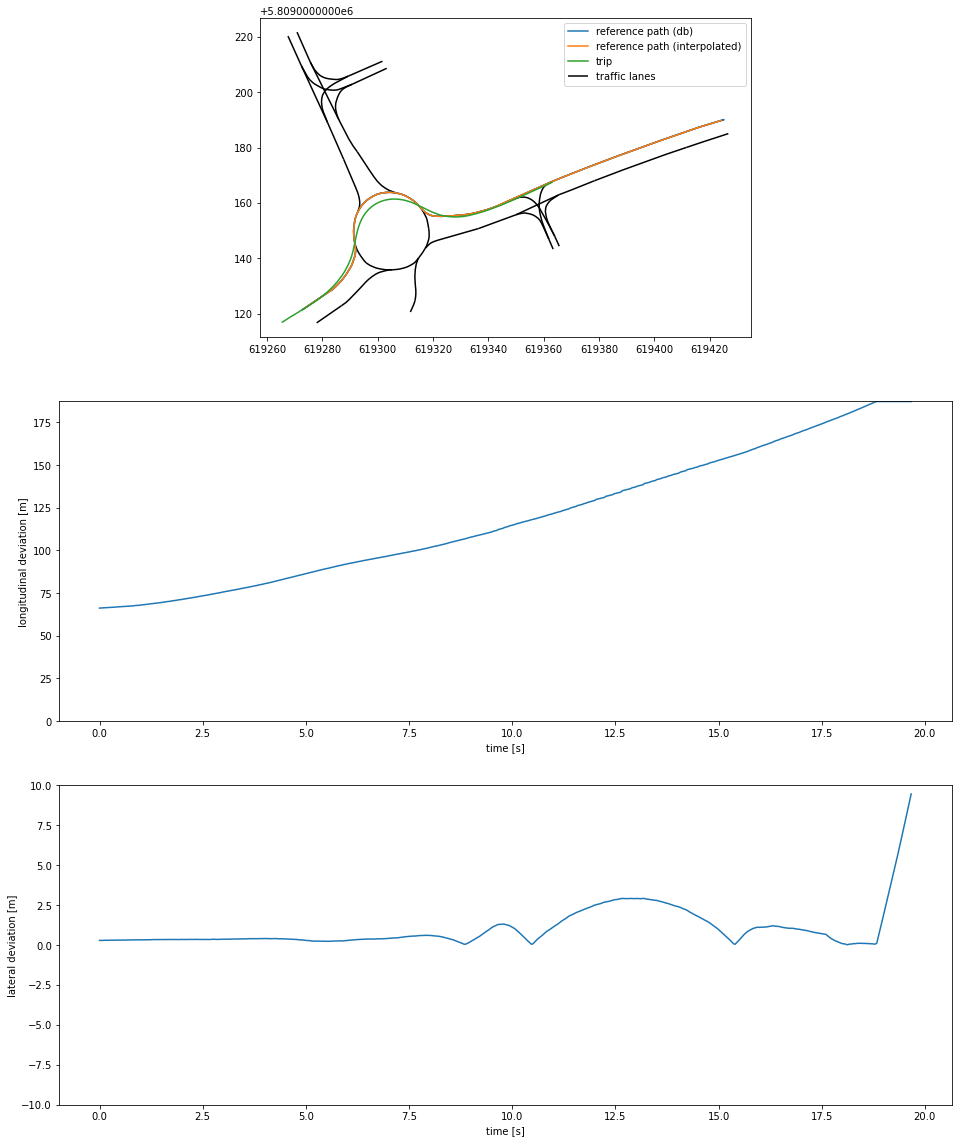

In [72]:
fig, (ax_cart, ax_frenet_lon, ax_frenet_lat) = plt.subplots(nrows=3, figsize=(16, 20))

trafficlanes.plot(ax=ax_cart, color="k", label="traffic lanes")
ax_cart.plot(*example_path.xy, label="reference path (db)")
ax_cart.plot(*example_reference.as_linestring().xy, label="reference path (interpolated)")
ax_cart.plot(*example_trip.geometry.xy, label="trip")
ax_cart.legend()

t_array = 1/30*np.arange(0, len(example_trip_frenet.xy[0]))
s_array, d_array = example_trip_frenet.xy
ax_frenet_lon.plot(t_array, s_array)
ax_frenet_lat.plot(t_array, d_array)

ax_frenet_lon.set_ylabel("longitudinal deviation [m]")
ax_frenet_lat.set_ylabel("lateral deviation [m]")

ax_frenet_lon.set_xlabel("time [s]")
ax_frenet_lat.set_xlabel("time [s]")


ax_frenet_lon.set_ylim([0, example_reference.length])
ax_frenet_lat.set_ylim([-10, 10])

## Project to frenet for all trajectories

In [73]:
reference_paths = [DiscreteReferencePath.from_linestring(dp.path, resolution=0.05) for dp in paths]

In [74]:
def row_to_frenet(row: pd.Series, reference_paths: List[DiscreteReferencePath]) -> LineString:
    path_id = row["path_id"]
    ref_path = reference_paths[path_id]
    return ref_path.linestring_to_frenet(row["geometry"])

In [75]:
gdf_traces["frenet_path"] = gpd.GeoSeries(gdf_traces.apply(lambda row: row_to_frenet(row, reference_paths), axis=1))

C:\Users\kopyt\AppData\Local\Temp/ipykernel_8236/2581116098.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


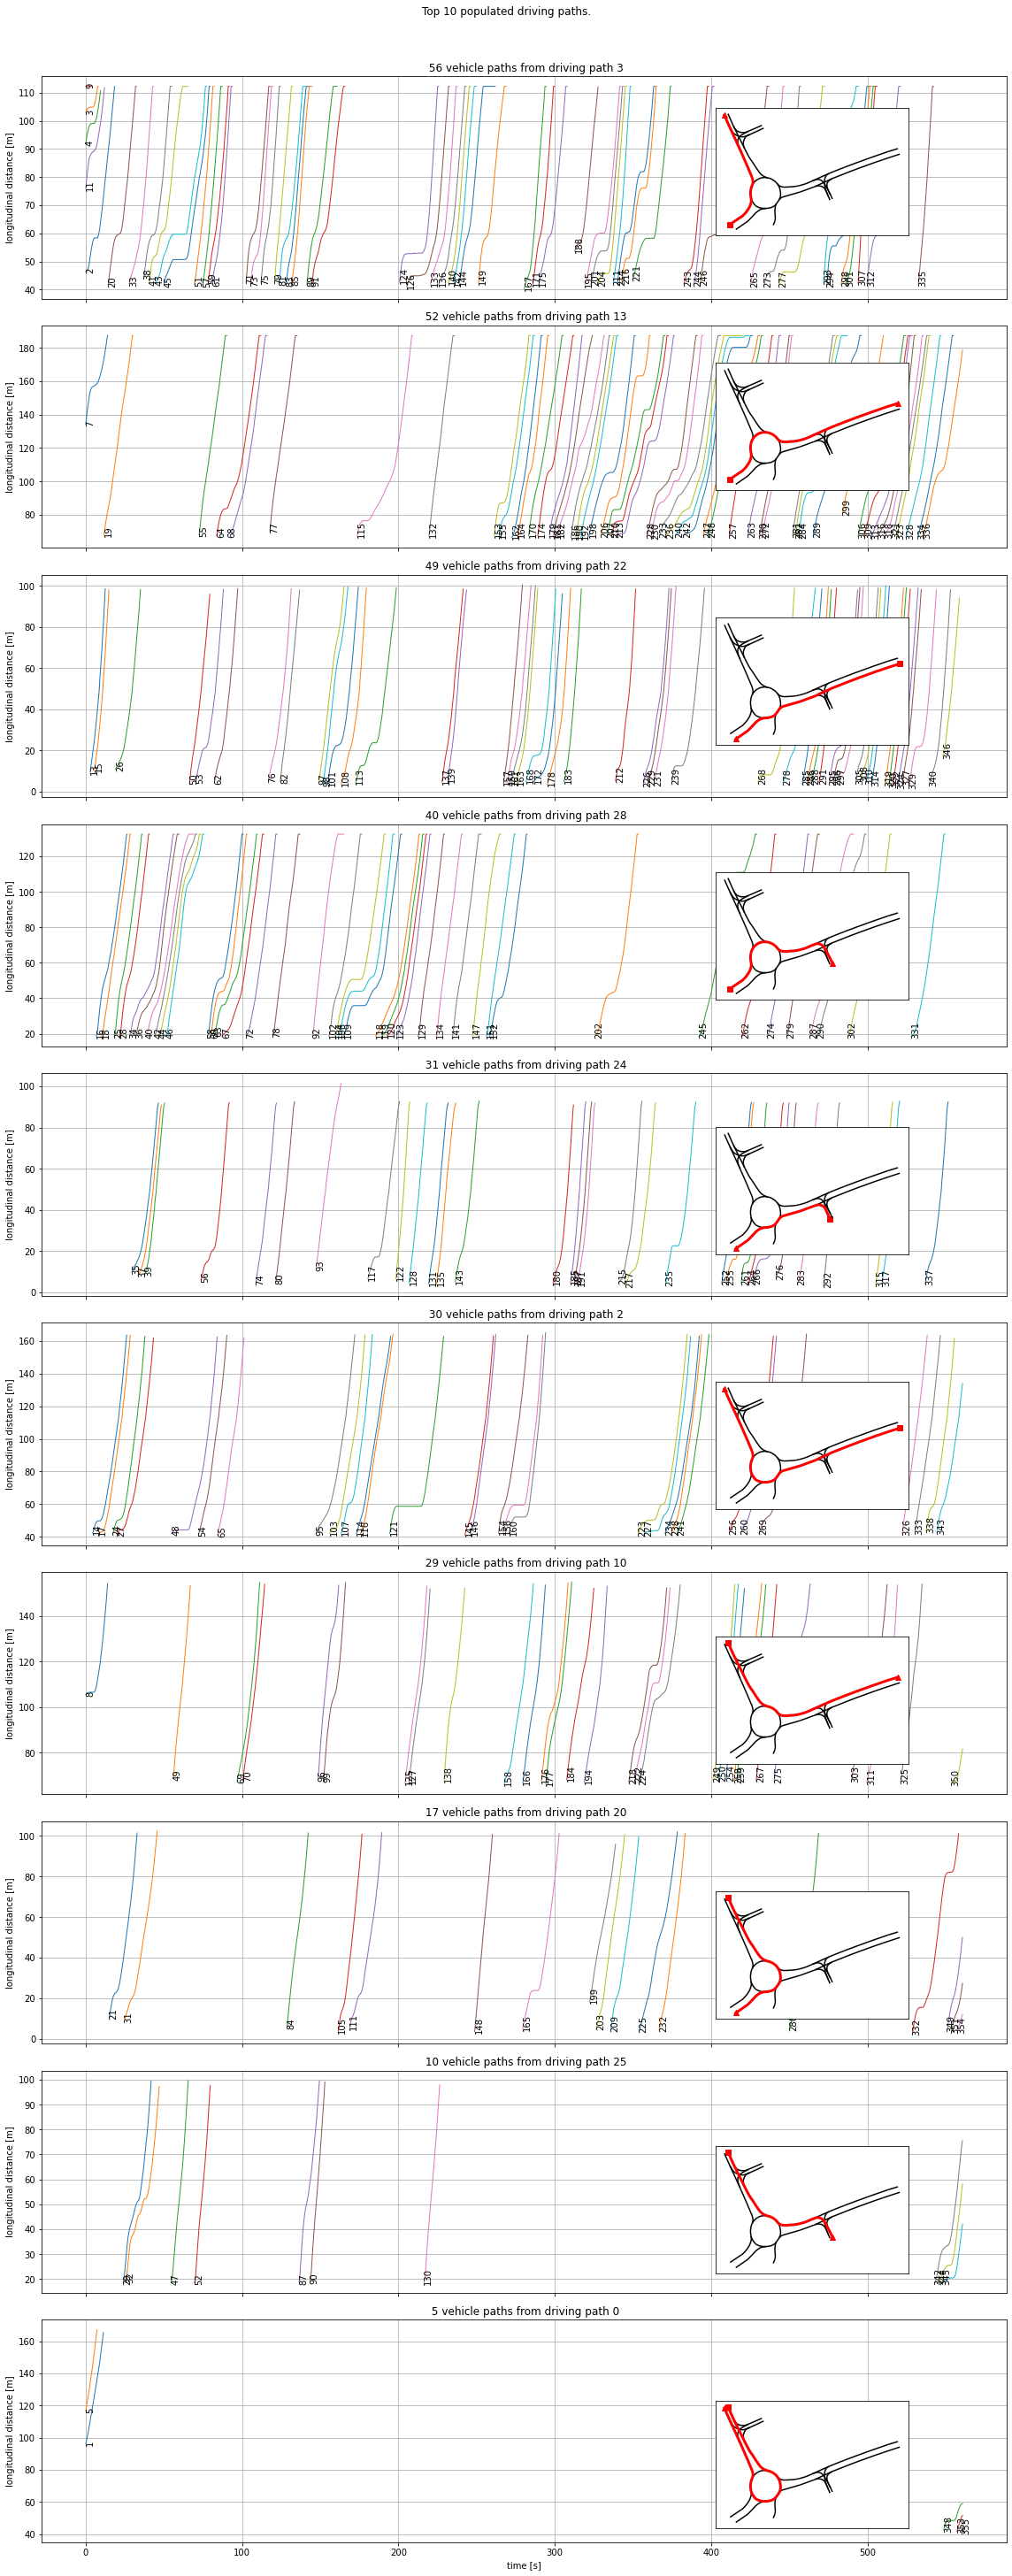

In [80]:
N = 10

fig, axs = plt.subplots(nrows=N, figsize=(16, 4*N), sharex=True)

toplist_path = gdf_traces["path_id"].value_counts()

for i, (path_id, cnt) in enumerate(toplist_path.iloc[:N].iteritems()):
    
    ax = axs[i]
    
    map_ax = fig.add_axes([0.7, 0.92 - 1/N*i, 0.2, 1/N*0.5])
    
    trafficlanes.plot(ax=map_ax, color="k", label="road network")
    paths[path_id].plot(map_ax, color="red")
    
    vehicle_paths = gdf_traces[gdf_traces["path_id"]==path_id]
    # map_ax.set_axis_off()
    map_ax.axes.get_xaxis().set_visible(False)
    map_ax.axes.get_yaxis().set_visible(False)
    
    for _, vp in vehicle_paths.iterrows():
        
        lon_array, lat_array = vp["frenet_path"].xy
        time_array = vp["START_TIME"] + 1/VEHICLE_SAMPLE_RATE*np.arange(0, vp["NUM_SAMPLES"])
        ax.plot(time_array, lon_array, lw=1)
        ax.text(time_array[0], lon_array[0], str(vp.name), fontsize=10, rotation="vertical")

    ax.set_title(f"{cnt: d} vehicle paths from driving path {path_id:d}")
    
    ax.grid()
    ax.set_ylabel("longitudinal distance [m]")
    
axs[-1].set_xlabel("time [s]")
    
fig.suptitle(f"Top {N} populated driving paths.", y=1.01)
plt.tight_layout()

In [87]:
print("# List of paths and corresponding objects:\n")
for path_id, row in gdf_traces.groupby("path_id").agg({"V": lambda df: list(df.index)}).iterrows():
    print(f"Path {path_id:03d}:", row["V"])

# List of paths and corresponding objects:

Path 000: [1, 5, 348, 353, 355]
Path 002: [14, 17, 24, 27, 48, 54, 65, 95, 103, 107, 114, 116, 121, 145, 146, 154, 156, 160, 223, 227, 234, 238, 241, 256, 260, 269, 326, 333, 338, 343]
Path 003: [2, 3, 4, 9, 11, 20, 33, 38, 41, 43, 45, 51, 57, 59, 61, 71, 73, 75, 79, 81, 83, 85, 89, 91, 124, 126, 133, 136, 140, 142, 144, 149, 167, 171, 175, 188, 195, 201, 204, 211, 214, 216, 221, 243, 244, 246, 265, 273, 277, 293, 294, 298, 301, 307, 312, 335]
Path 004: [110]
Path 010: [8, 49, 69, 70, 96, 99, 125, 127, 138, 158, 166, 176, 177, 184, 194, 218, 222, 224, 249, 250, 254, 258, 259, 267, 275, 303, 311, 325, 350]
Path 012: [112, 339, 341]
Path 013: [7, 19, 55, 64, 68, 77, 115, 132, 153, 155, 162, 164, 170, 174, 179, 181, 182, 186, 190, 192, 198, 206, 207, 210, 213, 228, 230, 233, 236, 240, 242, 247, 248, 257, 263, 270, 272, 281, 282, 284, 289, 299, 306, 309, 313, 316, 318, 321, 323, 328, 334, 336]
Path 014: [173, 356]
Path 015: [66, 86, 271]
Path 017

# Identify "drive offs"

In [88]:
# add position on the path
gdf_traces["S"] = gdf_traces["frenet_path"].apply(lambda row: row.xy[0])

## Single example

In [89]:
vp1 = gdf_traces.query("OBJID == 195").iloc[0]
vp2 = gdf_traces.query("OBJID == 201").iloc[0]

In [90]:
cols = ["S", "V", "ACC", "STATE"]
traj1, traj2 = Trajectory.from_trace(vp1, cols), Trajectory.from_trace(vp2, cols)

In [91]:
def identify_driveoffs(states: pd.Series) -> List[float]:
    
    state_change = np.diff(states)
    
    d = VehicleState.DRIVING.value - VehicleState.STANDING.value
    state_change_indices = np.nonzero(state_change == d)[0] + 1
    
    if len(state_change_indices) < 1:
        return []
    else:
        res_list = list()
        for i in state_change_indices:
            res_list.append(states.index[i])
        return res_list

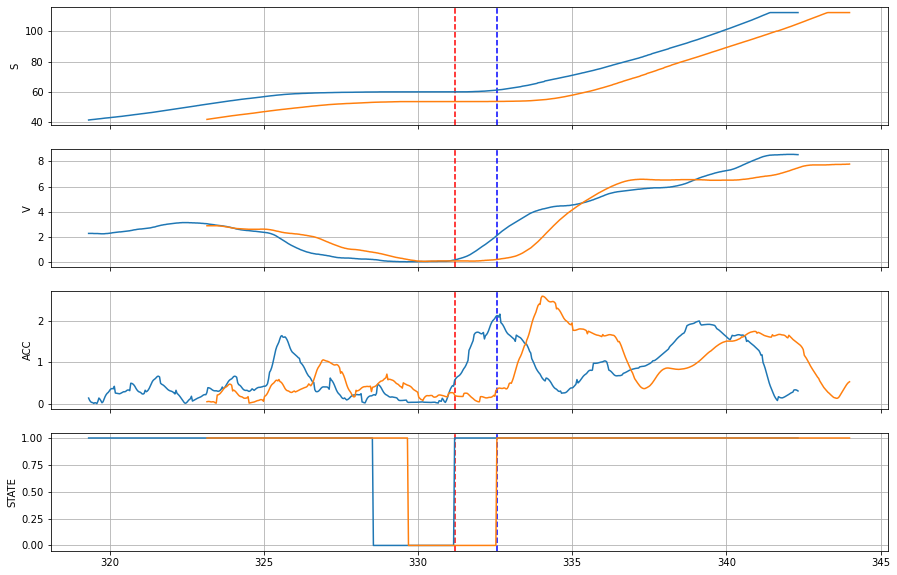

In [92]:
fig, axs = plt.subplots(nrows=traj1.dim, figsize=(15, 10), sharex=True)

for i, ax in enumerate(axs):
    ax.set_ylabel(traj1.names[i])
    ax.grid()
    
    
    for t in identify_driveoffs(traj1.get("STATE")):
        ax.axvline(t, color="r", ls="--")
        
    for t in identify_driveoffs(traj2.get("STATE")):
        ax.axvline(t, color="b", ls="--")
    
traj1.plot(axs, cols[:])
traj2.plot(axs, cols[:])



In [ ]:
@dataclass
class DriveOffSituation:
    
    o1_id: int
    o2_id: int
    
    t: float
    
    distance: float
    
    o2_state: VehicleState
    o2_timedelta_drive_off: Optional[float] 

In [ ]:
def analyze_drive_offs(traj1: Trajectory, traj2: Trajectory) -> List[DriveOffSituation]:
    
    common_time_range =  traj1.temporal_intersection(traj2) 
    if common_time_range[0] > common_time_range[1]:
        return list()
    
    o1_veh_states = traj1.get("STATE")
    o2_veh_states = traj2.get("STATE")
    
    o1_drive_offs = identify_driveoffs(o1_veh_states)
    o2_drive_offs = identify_driveoffs(o2_veh_states)
    
    if len(o1_drive_offs) < 1:
        # return empty list
        return list()
    
    o2_drive_offs = np.array(o2_drive_offs)
    
    situations = list()
    
    # for each drive-off of the first object
    for t_drive_off in o1_drive_offs:
        
        o1_state = traj1.sample(t_drive_off)
        o1_position_lon = o1_state["S"]
        
        # sample state of the second
        o2_state = traj2.sample(t_drive_off)
        
        o2_driving_state = int(o2_state["STATE"])
        
        o2_position_lon = o2_state["S"]
        
        distance = o1_position_lon - o2_position_lon
        
        if o2_driving_state == VehicleState.STANDING:
            time_drive_off_after_first = o2_drive_offs[o2_drive_offs >= t_drive_off][0]
            
            time_delta = time_drive_off_after_first - t_drive_off
            
            situation = DriveOffSituation(traj1.name, traj2.name, t_drive_off, distance, 
                                            VehicleState.STANDING, time_delta)
            
            situations.append(situation)
        
        elif o2_driving_state == VehicleState.DRIVING:
            situation = DriveOffSituation(traj1.name, traj2.name, t_drive_off, distance, 
                                            VehicleState.STANDING, None)
            situations.append(situation)
        else:
            raise ValueError("Interesting ...")
    return situations

In [ ]:
drive_off_situations = analyze_drive_offs(traj1, traj2)

In [ ]:
pd.DataFrame(drive_off_situations)

## All drive-offs from a path

In [ ]:
from itertools import tee

In [ ]:
def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [ ]:
def analyze_driveoffs_from_path(path_trajectories: gpd.GeoDataFrame) -> pd.DataFrame:
    # Assumptions: NO OVERTAKES!
    
    # identify the starting (long.) location of each trajectory for sorting
    # would fail in the first second, if not done
    path_trajectories["START_LON"] = path_trajectories["frenet_path"].apply(lambda ls: ls.xy[0][0])
    
    path_trajectories = path_trajectories.sort_values(["START_TIME", "START_LON"], ascending=[True, False])
    
    situations = list()
    for i, (o1, o2) in enumerate(pairwise(range(len(path_trajectories)))):
        o1_row = path_trajectories.iloc[o1]
        o2_row = path_trajectories.iloc[o2]
        
        cols = ["S", "V", "ACC", "STATE"]
        traj1, traj2 = Trajectory.from_trace(o1_row, cols), Trajectory.from_trace(o2_row, cols)
        
        drive_off_situations = analyze_drive_offs(traj1, traj2)
        situations += drive_off_situations
        
    df_situations = pd.DataFrame(situations)
        
    return df_situations

In [ ]:
df_situations = gdf_traces.groupby("path_id").apply(analyze_driveoffs_from_path)
df_situations["o1_id"] = df_situations["o1_id"].astype(int)
df_situations["o2_id"] = df_situations["o2_id"].astype(int)
df_situations["o2_state"] = df_situations["o2_state"].astype(int)

In [ ]:
df_situations.sort_values("o2_timedelta_drive_off").head(10)

In [ ]:
df_situations[df_situations["o2_state"] == VehicleState.STANDING]["o2_timedelta_drive_off"].describe()

In [ ]:
len(df_situations)

In [ ]:
gdf_traces.head()

In [ ]:
def visualize_object_traces(objects: List[int]) -> mpl.figure.Figure:
    
    traces = [gdf_traces.query(f"OBJID == {obj:d}").iloc[0] for obj in objects]
    
    cols = ["S", "V", "ACC", "STATE"]
    trajs = [Trajectory.from_trace(trace, cols) for trace in traces]
    
    fig, axs = plt.subplots(nrows=trajs[0].dim, figsize=(15, 10), sharex=True)
    
    for traj in trajs:
        traj.plot(axs, cols[:]) 

    for i, ax in enumerate(axs):
        ax.set_ylabel(trajs[0].names[i])
        ax.grid()
        
    axs[-1].set_yticks([VehicleState.STANDING.value, VehicleState.DRIVING.value])
    axs[-1].set_yticklabels([VehicleState.STANDING.name, VehicleState.DRIVING.name])
        
    return fig

In [ ]:
visualize_object_traces([201, 204]);